In [1]:
import os
import numpy as np
import pandas as pd
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt

import scipy.io as sio
from skimage.transform import resize
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import r2_score
from skimage.metrics import mean_squared_error, structural_similarity, peak_signal_noise_ratio

import torch
import torch.nn as nn
import torch.optim as optim

from utils import Units, check_torch, pix2vid_dataset, DualCustomLoss, DualLpLoss, NeuralPix2Vid

In [2]:
NR, NT = 1272, 40
NX, NY = 40, 40
units  = Units()
folder = 'simulations_40x40'
device = check_torch()

------------------------------------------------------------
----------------------- VERSION INFO -----------------------
Torch version: 2.3.1.post300 | Torch Built with CUDA? True
# Device(s) available: 1, Name(s): NVIDIA GeForce RTX 3090
Torch device: cuda
------------------------------------------------------------


In [3]:
tt = np.load('{}/timesteps.npz'.format(folder))
timesteps, deltaTime = tt['timesteps'], tt['deltatime']
t0steps = timesteps[:20]
print('timesteps: {} | deltaT: {}'.format(len(timesteps), np.unique(deltaTime)))

tops2d = sio.loadmat('{}/Gt.mat'.format(folder), simplify_cells=True)['Gt']['cells']['z'].reshape(NX,NY,order='F')
print('tops2d: {}'.format(tops2d.shape))

timesteps: 40 | deltaT: [  0.5 250. ]
tops2d: (40, 40)


In [4]:
(Xt, ct, y1t, y2t, all_volumes, idx), (trainloader, validloader) = pix2vid_dataset(folder='simulations_40x40',
                                                                                   batch_size=32,
                                                                                   send_to_device=True,
                                                                                   device=device)

X: (1272, 4, 40, 40) | c: (1272, 20, 5) | y1: (1272, 20, 2, 40, 40) | y2: (1272, 20, 1, 40, 40)
----------------------------------------------------------------------------------------------------
Train - X:  torch.Size([1000, 4, 40, 40])     | c:  torch.Size([1000, 20, 5])
        y1: torch.Size([1000, 20, 2, 40, 40]) | y2: torch.Size([1000, 20, 1, 40, 40])
--------------------
Valid - X:  torch.Size([136, 4, 40, 40])     | c:  torch.Size([136, 20, 5])
        y1: torch.Size([136, 20, 2, 40, 40]) | y2: torch.Size([136, 20, 1, 40, 40])
--------------------
Test  - X:  torch.Size([136, 4, 40, 40])     | c:  torch.Size([136, 20, 5])
        y1: torch.Size([136, 20, 2, 40, 40]) | y2: torch.Size([136, 20, 1, 40, 40])


In [5]:
model = NeuralPix2Vid(device=device).to(device)
nparams = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('# parameters: {:,} | device: {}'.format(nparams, model.device))
criterion = DualLpLoss().to(device)
#criterion = DualCustomLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# parameters: 4,261,815 | device: cuda


In [6]:
start = time()
epochs, monitor = 100, 5
train_loss, valid_loss = [], []
for epoch in range(epochs):
    epoch_train_loss = []
    model.train()
    for i, (x,c,y1,y2) in enumerate(trainloader):
        optimizer.zero_grad()
        u1, u2 = model(x,c)
        loss = criterion(y1, y2, u1, u2)
        loss.backward()
        optimizer.step()
        epoch_train_loss.append(loss.item())
    train_loss.append(np.mean(epoch_train_loss))
    # validation
    model.eval()
    epoch_valid_loss = []
    with torch.no_grad():
        for i, (x,c,y1,y2) in enumerate(validloader):
            u1, u2 = model(x,c)
            loss = criterion(y1, y2, u1, u2)
            epoch_valid_loss.append(loss.item())
    valid_loss.append(np.mean(epoch_valid_loss))
    # progress
    if (epoch+1) % monitor == 0:
        print('Epoch: [{}/{}] | Train Loss: {:.5f} | Valid Loss: {:.5f}'.format(epoch+1, epochs, train_loss[-1], valid_loss[-1]))

print('Total training time: {:.3f} minuts'.format((time()-start)/60))
torch.save(model.state_dict(), 'neural-pix2vid_model.pth')
losses = pd.DataFrame({'train': train_loss, 'valid': valid_loss})
losses.to_csv('neural-pix2vid_losses.csv', index=False)

Epoch: [5/100] | Train Loss: 1.10636 | Valid Loss: 1.09315
Epoch: [10/100] | Train Loss: 1.05936 | Valid Loss: 1.05275
Epoch: [15/100] | Train Loss: 1.03640 | Valid Loss: 1.03050
Epoch: [20/100] | Train Loss: 1.01904 | Valid Loss: 1.01434
Epoch: [25/100] | Train Loss: 1.00269 | Valid Loss: 0.99818
Epoch: [30/100] | Train Loss: 0.98570 | Valid Loss: 0.98239
Epoch: [35/100] | Train Loss: 0.97063 | Valid Loss: 0.96753
Epoch: [40/100] | Train Loss: 0.95825 | Valid Loss: 0.95575
Epoch: [45/100] | Train Loss: 0.94892 | Valid Loss: 0.94648
Epoch: [50/100] | Train Loss: 0.94040 | Valid Loss: 0.93884
Epoch: [55/100] | Train Loss: 0.93342 | Valid Loss: 0.93205
Epoch: [60/100] | Train Loss: 0.92735 | Valid Loss: 0.92566
Epoch: [65/100] | Train Loss: 0.92050 | Valid Loss: 0.91954
Epoch: [70/100] | Train Loss: 0.91352 | Valid Loss: 0.91284
Epoch: [75/100] | Train Loss: 0.90622 | Valid Loss: 0.90483
Epoch: [80/100] | Train Loss: 0.89510 | Valid Loss: 0.89381
Epoch: [85/100] | Train Loss: 0.87838 | V

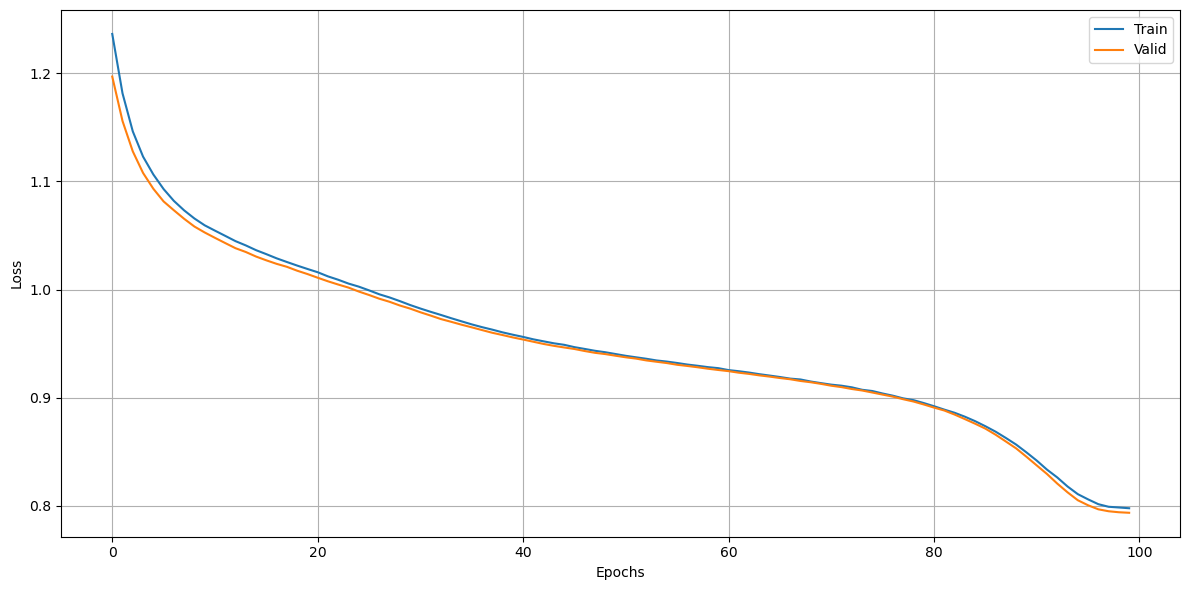

In [8]:
plt.figure(figsize=(12,6))
plt.plot(losses.index, losses['train'], label='Train')
plt.plot(losses.index, losses['valid'], label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, which='both')
plt.tight_layout()
plt.savefig('neural-pix2vid_losses.png')
plt.show()

***
# END